# CPI Analysis

In [19]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram

## Define function

In [2]:
def read_data(filename):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
    df.set_index('Date', inplace=True)

    name = os.path.splitext(os.path.basename(filename))[0]

    return df.copy(), name.capitalize()

In [3]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [4]:
def seasonal_analyze(data, name, save_file_name, period, time_flag, model, save=False):
    if len(data) == 0: return
    target_name = f"{'' if 'cpi' in name.lower() else 'CPI of'} {name}"
    base_path = f"../out/graph/{name}"
    save_path = f"{base_path}/{save_file_name}"
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(15, 6.4))
    plt.plot(data, linestyle="-", label=target_name)
    plt.title(f"{name} in {time_flag}")
    if save: plt.savefig(f"{save_path}/{save_file_name}-Observation")
    plt.show()

    frequencies, spectrum = periodogram(data)
    plt.figure(figsize=(15, 6.4))
    plt.plot(frequencies, spectrum)
    plt.xlabel('Frequency')
    plt.ylabel('Spectral Density')
    plt.title(f'Periodogram of {target_name} in {time_flag}')
    if save: plt.savefig(f"{save_path}/{save_file_name}-Periodogram")
    plt.show()

    season = seasonal_decompose(data, model=model, period=period)
    fig = season.plot()
    fig.suptitle(f"Seasonal Decomposition of {target_name} in {time_flag}")
    fig.set_figwidth(15)
    fig.set_figheight(6.4)
    plt.tight_layout()
    if save: plt.savefig(f"{save_path}/{save_file_name}-Seasonal")
    plt.show()


    fig, ax = plt.subplots(1, 2)
    plot_acf(data, ax=ax[0])
    plot_pacf(data, ax=ax[1])
    fig.set_figwidth(15)
    fig.set_figheight(6.4)
    plt.tight_layout()
    if save: fig.savefig(f"{save_path}/{save_file_name}-Correlation")
    plt.show()

In [74]:
def data_analyze(data, name, folder_name):
    base_path = f"../out/report/{name}/{folder_name}"
    os.makedirs(base_path, exist_ok=True)

    overview = data.describe()
    
    data = data.copy().dropna()

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outliers.index = outliers.index.strftime("%m/%Y")

    overview["outliers count"] = outliers.count()

    plt.boxplot(data)
    plt.tight_layout()
    plt.title("Change with outliers")

    overview.to_csv(f"{base_path}/{folder_name}-overview.csv")
    outliers.to_csv(f"{base_path}/{folder_name}-outliers.csv")
    plt.savefig(f"{base_path}/{folder_name}-outliers-plot.png")

    return overview.copy(), outliers.copy()

## Input data

### Read data list

In [44]:
data_files = glob.glob("..\\data\\*.csv")
data_files

['..\\data\\cargo&services.csv',
 '..\\data\\clothing.csv',
 '..\\data\\communication.csv',
 '..\\data\\CPI.csv',
 '..\\data\\drink&cigarette.csv',
 '..\\data\\education.csv',
 '..\\data\\entertain.csv',
 '..\\data\\family.csv',
 '..\\data\\food.csv',
 '..\\data\\houseware.csv',
 '..\\data\\housing&building.csv',
 '..\\data\\medical.csv',
 '..\\data\\plant.csv',
 '..\\data\\traffic.csv',
 '..\\data\\transportation.csv']

### Read file

In [6]:
df, name = read_data("../data/CPI.csv")

In [7]:
df.describe()

,Value,Change
count,252.000000,252.000000
mean,100.526071,-0.004405
std,0.763647,0.696883
min,98.460000,-3.000000
25%,100.100000,-0.252500
50%,100.385000,0.040000
75%,100.777500,0.350000
max,103.910000,1.900000


### Preprocess data

In [8]:
df.dropna(inplace=True)
df.count() - len(df)

Value     0
Change    0
dtype: int64

## Analysis

### Stationarity test

Use Dickey-Fuller test to judge if the dataset is stationary or not

The smaller p-value, the better

If the p-value is too large, differencing the data will fix (maybe)

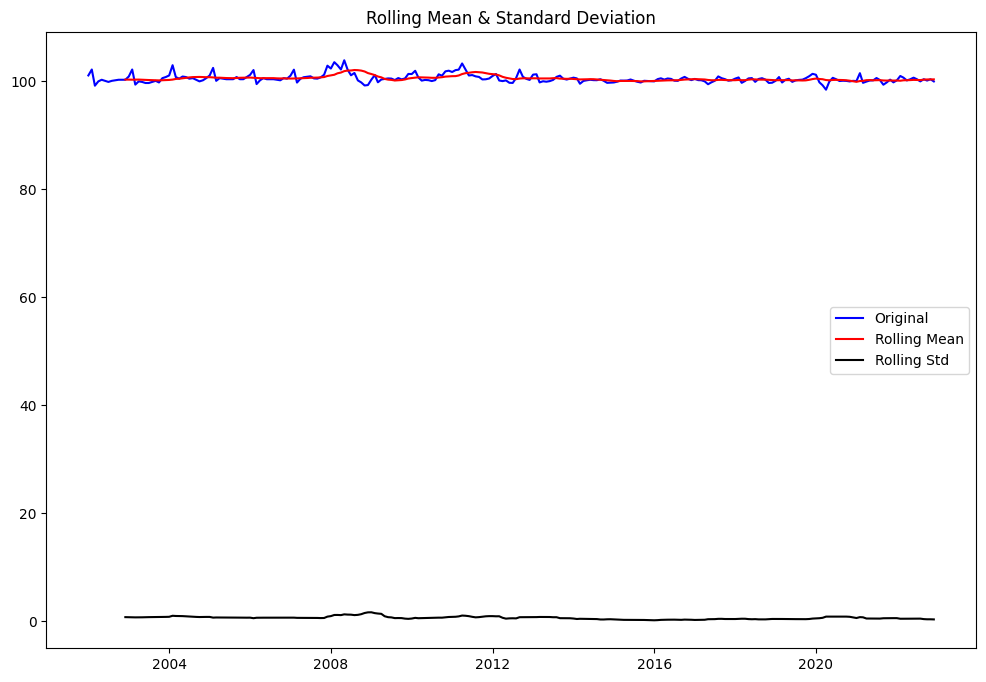

Results of Dickey-Fuller Test:
p-value = 0.0125. The series is likely non-stationary.
Test Statistic                  -3.358467
p-value                          0.012459
#Lags Used                      12.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


In [9]:
test_stationarity(df["Value"])

#### Differencing the data

In [ ]:
for _ in range(1): #differencing
    df['Value'] = df['Value'].diff()

df = df.dropna()
df['Value'].head()

### Seasonal decomposition

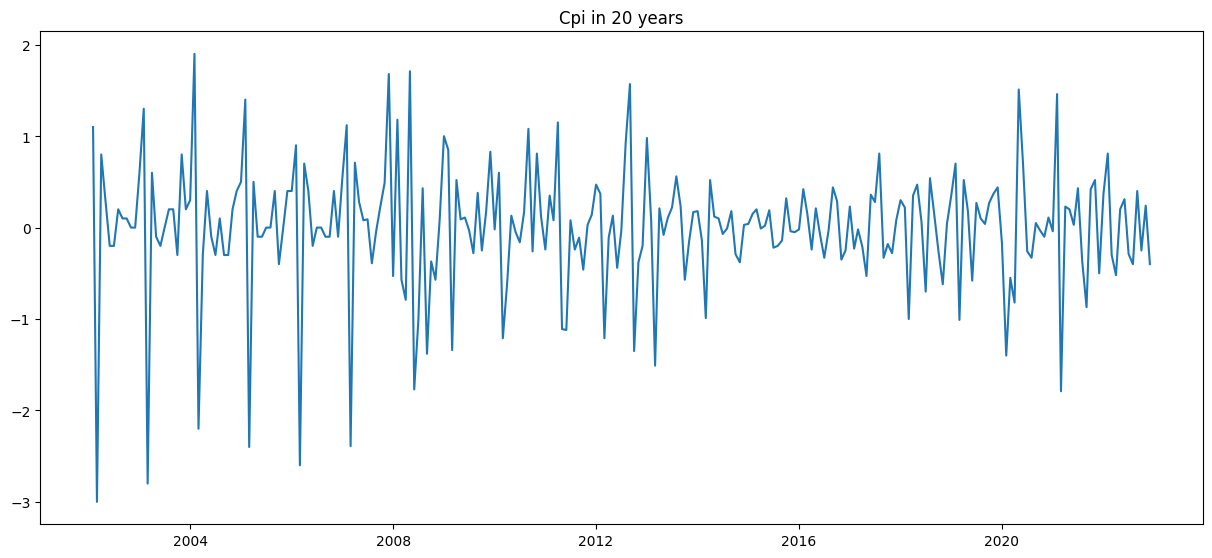

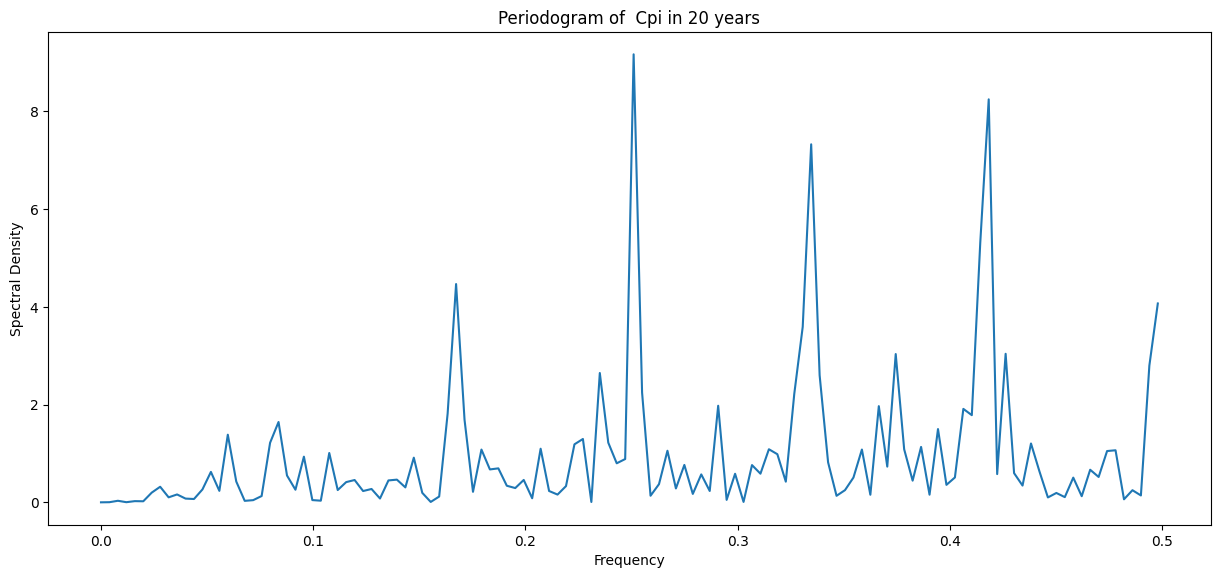

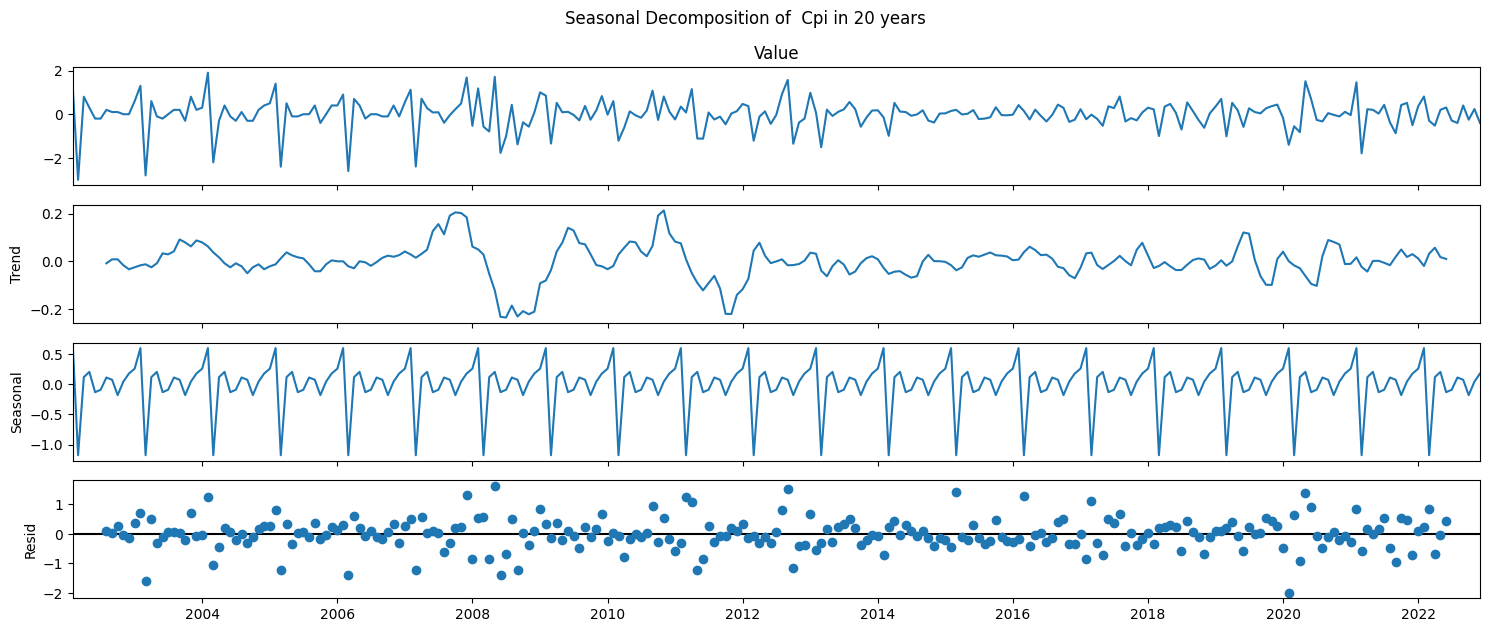

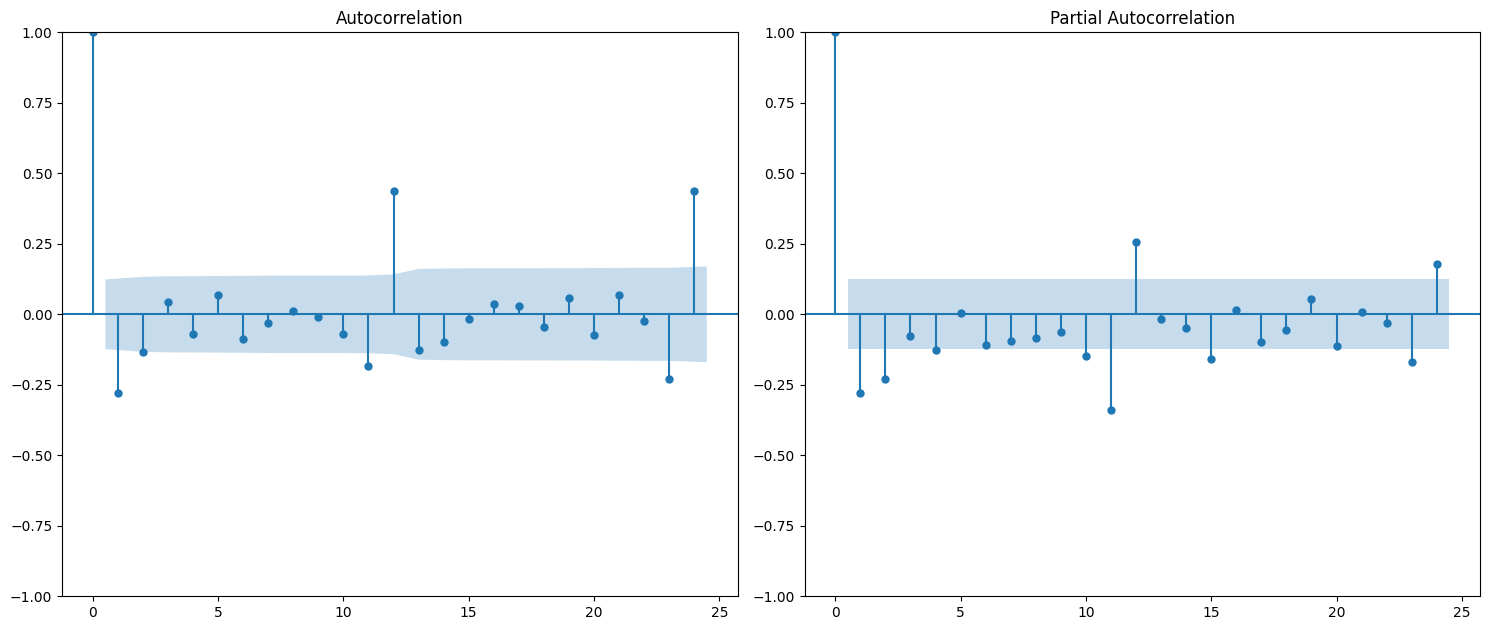

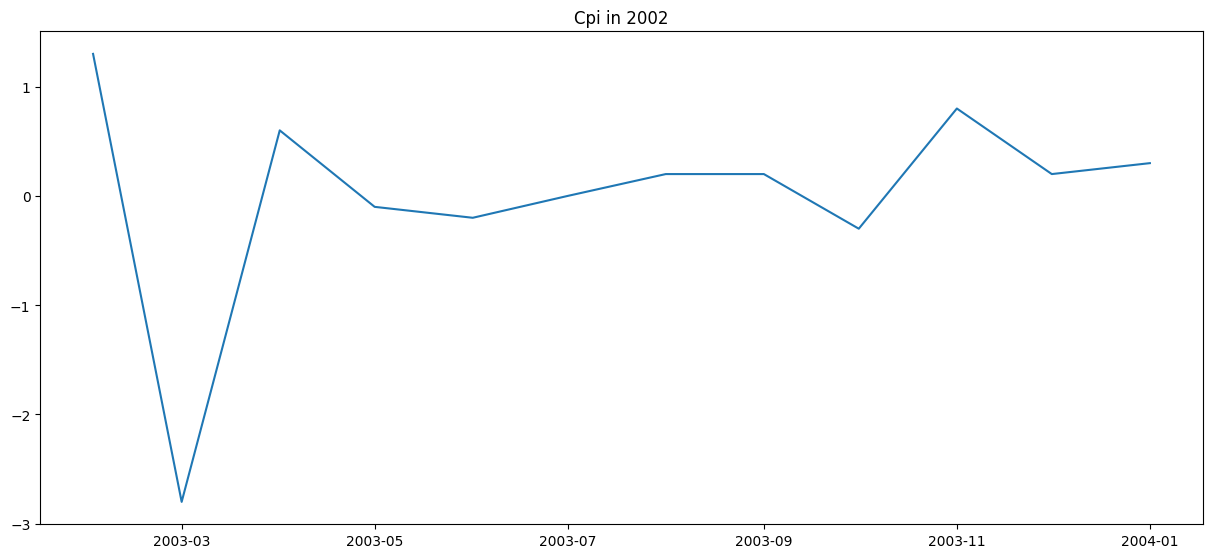

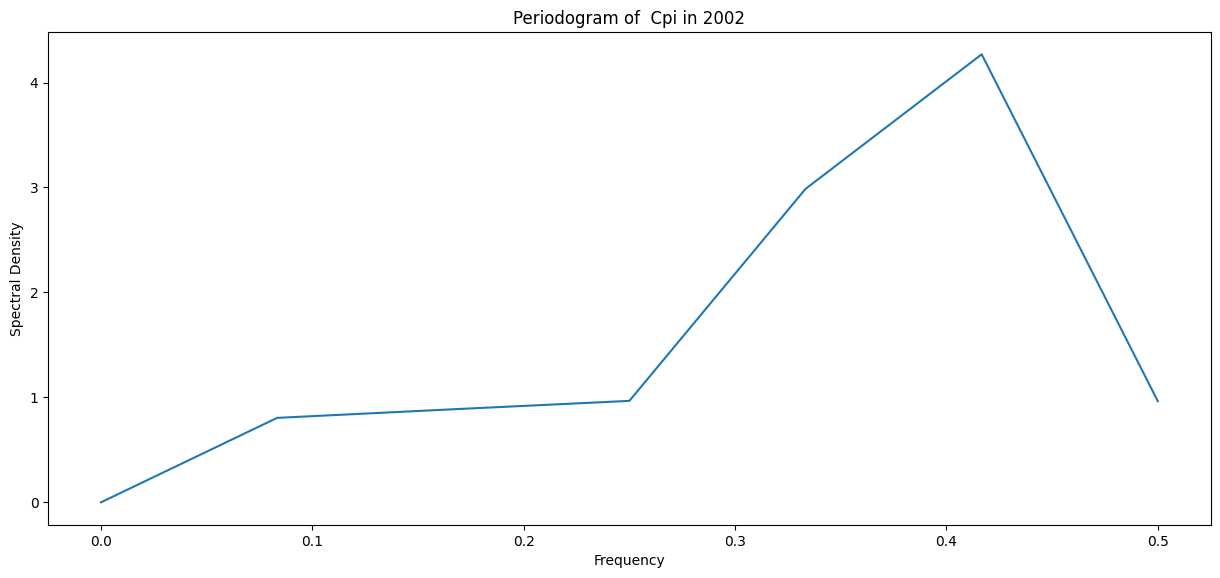

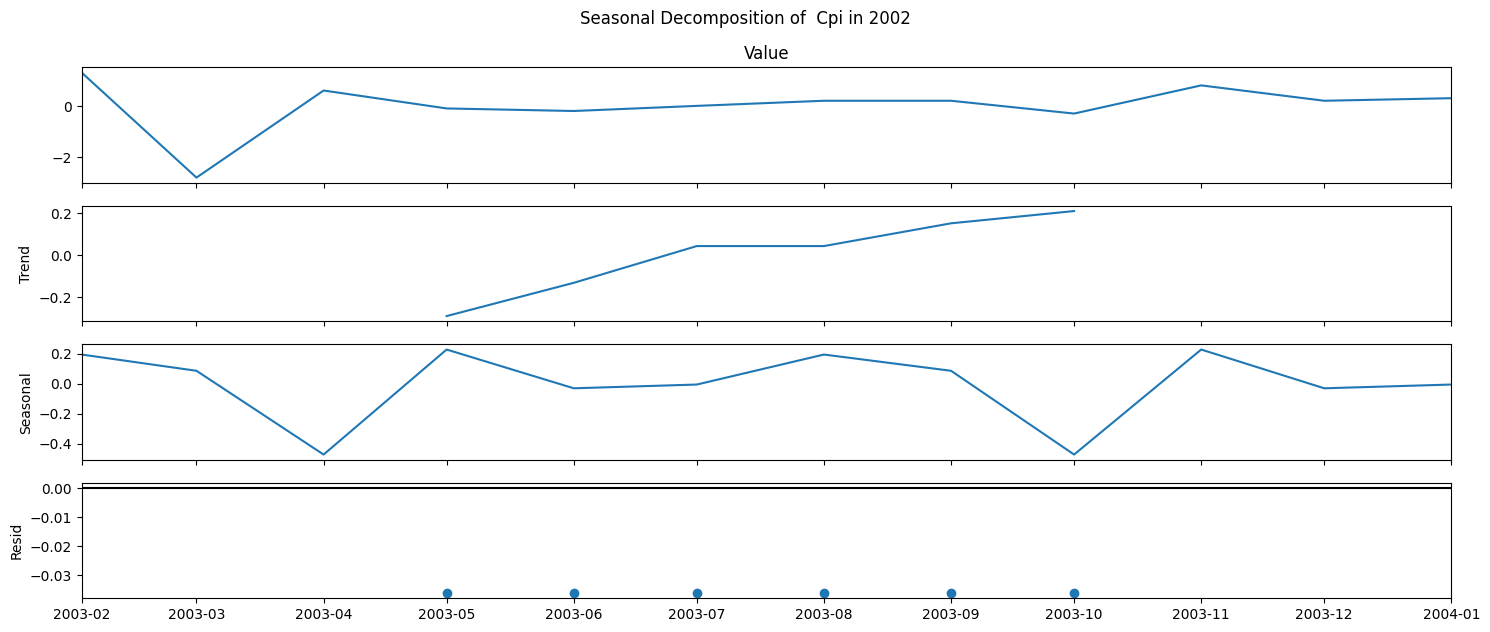

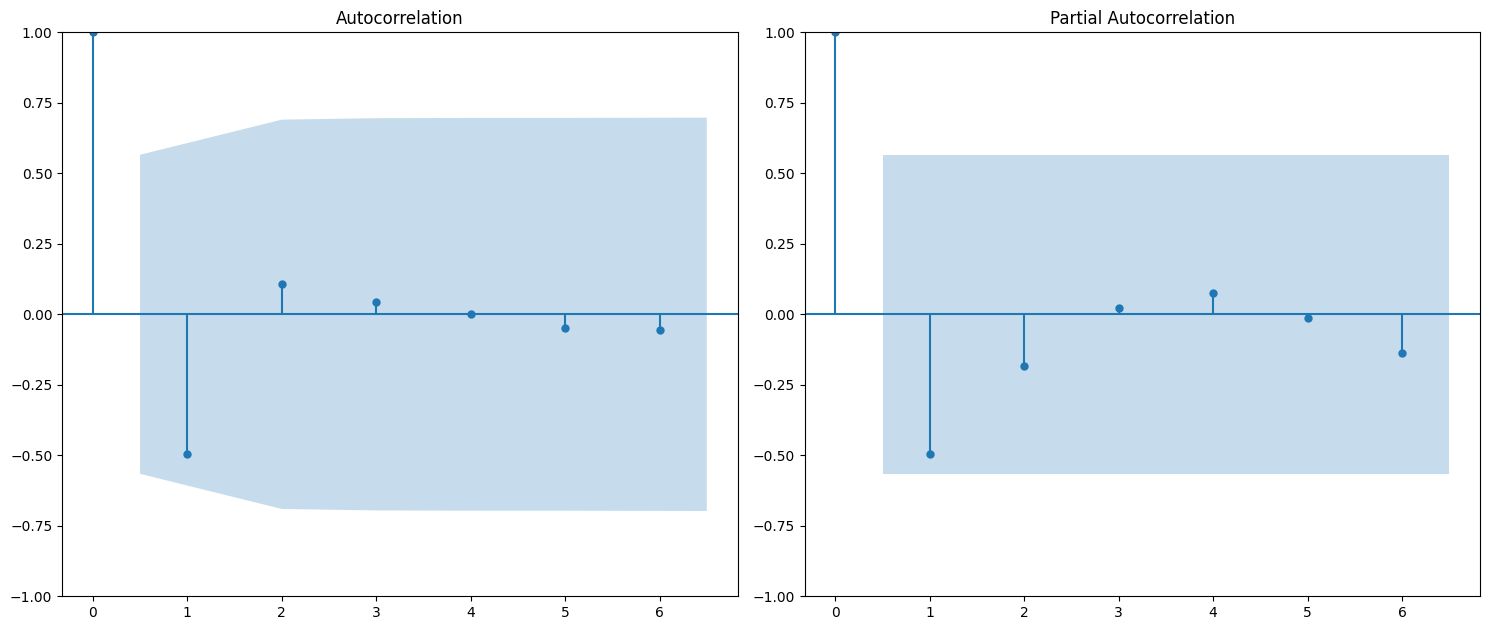

In [10]:
seasonal_analyze(df["Value"].diff().dropna(), name, "20years", period=12, time_flag="20 years", model="additive")
seasonal_analyze(df["Value"].diff().dropna()[12:24], name, 2002, period=6, time_flag=2002, model="additive")

### Further analysis

#### Find special data point

In [18]:
data = df['Change'].copy().dropna()

Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data < lower_bound) | (data > upper_bound)]
outliers.index = outliers.index.strftime("%m/%Y")
outliers

Date
03/2002   -3.00
02/2003    1.30
03/2003   -2.80
02/2004    1.90
03/2004   -2.20
02/2005    1.40
03/2005   -2.40
03/2006   -2.60
03/2007   -2.39
12/2007    1.68
05/2008    1.71
06/2008   -1.77
09/2008   -1.38
03/2009   -1.34
03/2010   -1.21
03/2012   -1.21
09/2012    1.57
10/2012   -1.35
03/2013   -1.51
02/2020   -1.40
05/2020    1.51
02/2021    1.46
03/2021   -1.79
Name: Change, dtype: float64

## Mass runner

Generate a bunch of graph from the data list

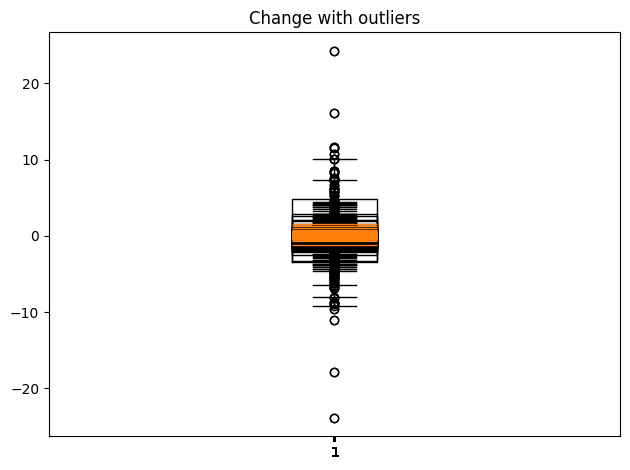

In [75]:
for file in data_files:
    df, name = read_data(file)
    
    # seasonal_analyze(df["Change"], name, f"{df.index.year.max() - df.index.year.min() + 1}years", period=12, time_flag=f"{df.index.year.max() - df.index.year.min() + 1} year(s)", model="additive", save=True)
    data_analyze(df["Change"], name, f"{df.index.year.max() - df.index.year.min() + 1}years")
    for i in range(1, 22):
        try:
            # seasonal_analyze(df[(i - 1) * 12 : i * 12]["Change"], name, i + 2001, period=6, time_flag=i + 2001, model="additive", save=True)
            data_analyze(df[(i - 1) * 12 : i * 12]['Change'], name, f"{i + 2001}")
        except Exception as e:
            pass

    